In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
cd '/content/gdrive/My Drive/VIP_Project/MNIST'

/content/gdrive/My Drive/VIP_Project/MNIST


In [3]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pylab as plt

In [4]:
num_epoch = 100
batch_size = 1000 #50

in_timesteps  = range(0,19)
out_timesteps = range(1,20)

# prepare data
data = np.load("moving-mnist-2-tr-images.npy" )

# training set
x_tr = data[0:10000, in_timesteps,  :, :]
y_tr = data[0:10000, out_timesteps, :, :]
x_tr = x_tr.reshape(x_tr.shape[0], len(in_timesteps),  64, 64, 1)
y_tr = y_tr.reshape(y_tr.shape[0], len(out_timesteps), 64, 64, 1)
tr_set = data[0:10000, :, :, :]

# validation set
x_te = data[10000:, in_timesteps,  :, :]
y_te = data[10000:, out_timesteps, :, :]
x_te = x_te.reshape(x_te.shape[0], len(in_timesteps),  64, 64, 1)
y_te = y_te.reshape(y_te.shape[0], len(out_timesteps), 64, 64, 1)
te_set = data[10000:, :, :, :]

print (np.shape(x_tr), np.shape(y_tr), np.shape(x_te), np.shape(y_te))

(10000, 19, 64, 64, 1) (10000, 19, 64, 64, 1) (1000, 19, 64, 64, 1) (1000, 19, 64, 64, 1)


In [5]:
#Build a model
seq = keras.Sequential(
    [
        keras.Input(
            shape=(None, 64, 64, 1)    # (64,64,1) for MNISt , (64,64,3) for moving shape
        ),  # Variable-length sequence of 40x40x1 frames
        layers.Conv3D(
            filters=64, kernel_size=(3, 3, 3), padding="same"
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=64, kernel_size=(3, 3, 3), padding="same"
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=64, kernel_size=(3, 3, 3), padding="same"
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=64, kernel_size=(3, 3, 3), padding="same"
        ),
        layers.BatchNormalization(),
        layers.Conv3D(
            filters=64, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
        ),
    ]
)
seq.compile(loss="binary_crossentropy", optimizer="adadelta")

In [6]:
seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d (Conv3D)              (None, None, 64, 64, 64)  1792      
_________________________________________________________________
batch_normalization (BatchNo (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, None, 64, 64, 64)  110656    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv3d_2 (Conv3D)            (None, None, 64, 64, 64)  110656    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 64, 64, 64)  256       
_________________________________________________________________
conv3d_3 (Conv3D)            (None, None, 64, 64, 64)  1

In [7]:
def generator(X, y, batch_size):
    while True:
        for start in range(0, len(X), batch_size):
            end = min(start + batch_size, len(X))
            yield np.array(X[start:end]/255), np.array(y[start:end]/255)

In [ ]:
batch_size=8

checkpoint_filepath = 'conv3D_checkpoint'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
  )

history = seq.fit_generator(
    generator(x_tr, y_tr, batch_size),
    steps_per_epoch = len(x_tr)/batch_size,
    epochs=500,
    verbose=1,
    validation_data=generator(x_te, y_te, batch_size),
    validation_steps = len(x_te)/batch_size,
    callbacks=[model_checkpoint_callback]
)

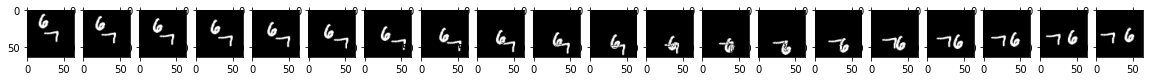

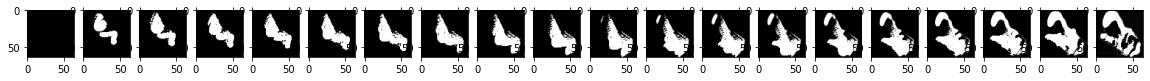

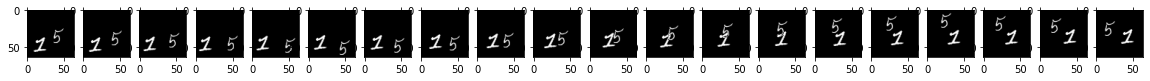

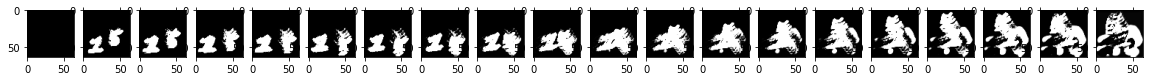

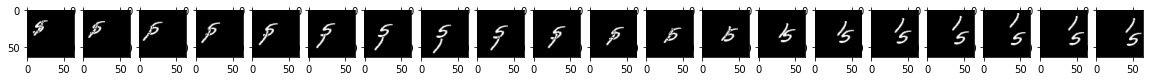

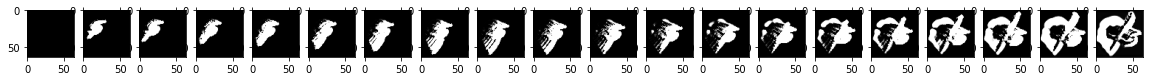

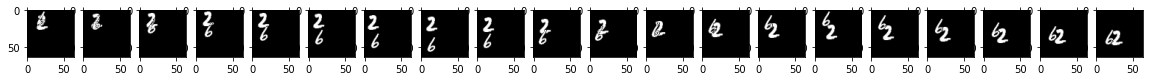

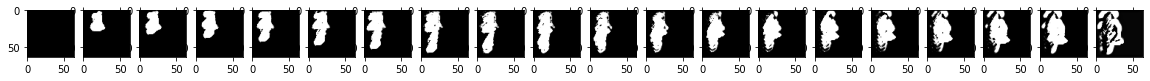

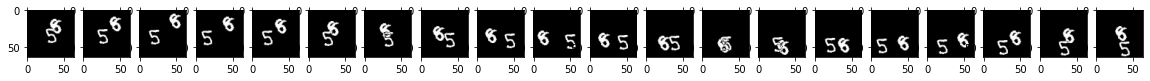

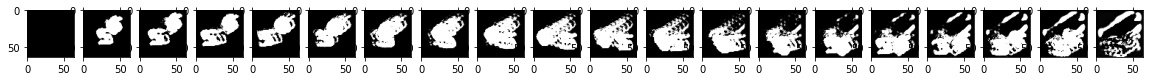

In [ ]:
for sequence in range(5):
    track = x_te[sequence, :20, ::, ::, ::]
    y_prediction = seq.predict(track[np.newaxis])
    #print(y_prediction.shape)
    # ground truth
    plt.figure(figsize=(20,10))
    for i in range(20):
        plt.subplot(1, 20, i+1)
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(te_set[sequence,i,:,:,0], cmap='gray')

    # prediction
    plt.figure(figsize=(20,10))
    plt.subplot(1,20,1)
    plt.imshow(np.zeros((64,64)), cmap='gray')
    for i in range(19):
        plt.subplot(1, 20, i+2) 
        plt.tick_params(
        axis='both',       # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off', # labels along the bottom edge are off
        labelleft='off')
        plt.imshow(y_prediction[0,i,:,:,0], cmap='gray')

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from skimage.metrics import structural_similarity as ssim
from skimage import img_as_float32

y_prediction = seq.predict(x_te[:, :20, ::, ::, ::])
te_set = img_as_float32(te_set)
batch_size=1000
mse_total=0
mae_total=0
ssim_total=0

mse=0
mae=0
ssim_v=0

for i in range(batch_size):
  for j in range(19):
    mse_total += mean_squared_error(te_set[i,j+1,:,:,0],y_prediction[i,j,:,:,0])
    mae_total += mean_absolute_error(te_set[i,j+1,:,:,0],y_prediction[i,j,:,:,0])
    ssim_total += ssim(te_set[i,j+1,:,:,0],y_prediction[i,j,:,:,0],data_range=y_prediction[i,j,:,:,0].max() - y_prediction[i,j,:,:,0].min())

mse = mse_total/(batch_size*19)
mae = mae_total/(batch_size*19)
ssim_v = ssim_total/(batch_size*19)
print('MSE: ',mse)
print('MAE: ',mae)
print('SSIM: ',ssim_v)